In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print('image shape', x_train[0].shape)

60000 train samples
image shape (28, 28)


In [5]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

input shape:  784


In [20]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)

In [21]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [22]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [23]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [24]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [25]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9 

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

4/4 [==============================] - 0s 4ms/step
epoch:  0
1/1 [==============================] - 0s 14ms/step


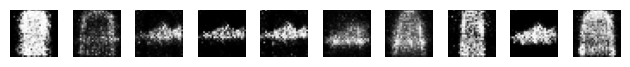

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
epoch:  20
1/1 [==============================] - 0s 14ms/step


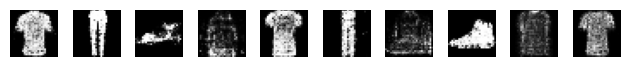

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
epoch:  40
1/1 [==============================] - 0s 16ms/step


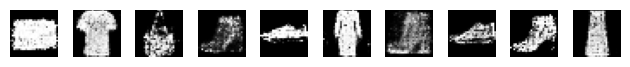

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
epoch:  60
1/1 [==============================] - 0s 14ms/step


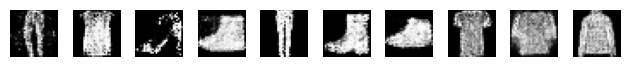

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 5ms/step
epoch:  80
1/1 [==============================] - 0s 28ms/step


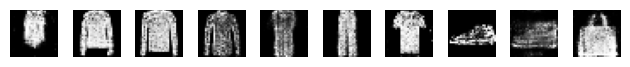

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 6ms/step
epoch:  100
1/1 [==============================] - 0s 19ms/step


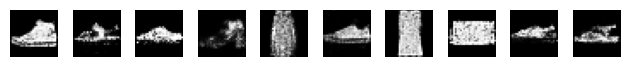

In [27]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)